**Part 5: Linear regression with strong correlations between features removed**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In part 1 we performed a linear regression using only the 34 numerical features. In part 2 we transformed 22 categorical features into numerical features via transformations, and performed a linear regression on the enlarged set of numerical features, 56 in total. In part 3 we removed those categorical values which we believe contain little information, incorporated the remaining categorical features using one-hot encoding, and performed a linear regression on the result. In part 4 we removed features which were weakly correlated with the train sale price in an attempt to reduce noise. In this part we investigate train features which are strongly correlated with each other.

Our motivation is to identify features which 'depend' on different features. Such 'dependant' features intuitively do not contribute much independent information to the sale price, since the other feature contains the relevant information. One of the dependant features should be removed, or the features should be combined in some way, to (hopefully) reducing noise. We will, for the moment, ignore the weak correlation investigation of part 4.

Mathematically, we wish to investigate the linear dependence of the train columns, and test columns. Without going into too much detail, partially linearly dependent columns would result in large errors when performing the linear regression, and so we wish to reduce the dependence of the columns. Of course correlation does not necessarily imply dependence. Nevertheless, strong correlations _may_ indicate that dependence exists, and so it worth investigating.

We begin by reproducing steps 1-3 of part 3, except for the log transformation of the train SalePrice, as it makes sense to wait until the correlation investigation is complete before doing this transformation. We do not remove any weak correlations (as in part 4) as we want to examine the effect of removing the strong correlations by themselves.

**Step 1: Reproduce steps 1-3 of part 3**

In [5]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

56
(1460, 213)
(1459, 213)


As a reminder, numeric_features_columns represents the extended set of 56 numerical features: The original 34 numerical features (part 0), and the 22 categorical features that we converted into numerical features via transformations (part 2). The other 157 = 213-56 numerical features were constructed from the categorical features via one-hot encoding (part 3).

**Step 2: The train correlation matrix, and compensating for strongly correlated features**

We now add the train SalePrice back to the train matrix, and investigate those train features with strong  correlations between themselves. Specifically, we identify pairs of train features whose correlations are between 0.8 and 1, and between -1 and -0.8. Also, in each pair, we identify which feature is more weakly correlated with the train SalePrice.

In [6]:
features = list(train.columns) # All feature names in train and test
train_correlations = pd.concat([train, train_sale_price['SalePrice']], axis=1).corr() # Dataframe with the correlations of all columns of train, including SalePrice

feature_pairs_with_strong_correlation = [] # Initialise list
features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice = [] # Initialise list

for feature1 in features: # For each feature1
    for feature2 in features[features.index(feature1)+1:]: # For each feature2 after feature1 in the list features
        
        if train_correlations[feature1][feature2] > .8 or train_correlations[feature1][feature2] < -.8: # Check if the correlation is strong, and add the pair to the list of pairs if so. Also check which feature is more weakly correlated with train SalePrice, and add that feature to the other list.
            feature_pairs_with_strong_correlation.append([feature1, feature2])
            
            if train_correlations[feature1]['SalePrice'] > train_correlations[feature2]['SalePrice']:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature2)
            else:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature1)

for item in feature_pairs_with_strong_correlation: # Print each pair in the list of pairs
    print(item)
print('')
for item in features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice: # Print each feature in the other list
    print(item)
print('')
print(len(feature_pairs_with_strong_correlation))
print(len(features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice))

['BsmtQual', 'BsmtCond']
['TotalBsmtSF', '1stFlrSF']
['2ndFlrSF', 'HouseStyle_2Story']
['GrLivArea', 'TotRmsAbvGrd']
['Fireplaces', 'FireplaceQu']
['GarageCars', 'GarageArea']
['GarageQual', 'GarageCond']
['GarageQual', 'GarageType_NA']
['GarageCond', 'GarageType_NA']
['PoolArea', 'PoolQC']
['MSZoning_FV', 'Neighborhood_Somerst']
['MSZoning_RL', 'MSZoning_RM']
['Exterior1st_AsbShng', 'Exterior2nd_AsbShng']
['Exterior1st_CBlock', 'Exterior2nd_CBlock']
['Exterior1st_CemntBd', 'Exterior2nd_CmentBd']
['Exterior1st_HdBoard', 'Exterior2nd_HdBoard']
['Exterior1st_MetalSd', 'Exterior2nd_MetalSd']
['Exterior1st_VinylSd', 'Exterior2nd_VinylSd']
['Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng']
['RoofStyle_Gable', 'RoofStyle_Hip']
['HouseStyle_1.5Fin', 'MSSubClass_50']
['HouseStyle_1.5Unf', 'MSSubClass_45']
['HouseStyle_SLvl', 'MSSubClass_80']
['BldgType_2fmCon', 'MSSubClass_190']
['BldgType_Duplex', 'MSSubClass_90']
['MasVnrType_BrkFace', 'MasVnrType_None']
['SaleCondition_Partial', 'SaleType_New']

The above gives 28 pairs of features which are strongly correlated. Checking entry 5 in both lists, train Fireplaces and FireplaceQu are strongly correlated, and train Fireplaces is more weakly correlated with train SalePrice than is train FireplaceQu. Lets take a look at the specific correlations in this example for the sake of clarity.

In [7]:
train_correlations.loc[['Fireplaces', 'FireplaceQu', 'SalePrice'], ['Fireplaces', 'FireplaceQu']]

,Fireplaces,FireplaceQu
Fireplaces,1.000000,0.863241
FireplaceQu,0.863241,1.000000
SalePrice,0.466929,0.520438


As observed above, train Fireplaces and FireplaceQu indeed have strongly correlation (0.863241). Moreover train Fireplaces and train SalePrice have correlation 0.489449, and train FireplaceQu and train SalePrice have a stronger correlation 0.546362. Also, in this case, it is not difficult to convince oneself that it is no coincidence that these are correlated since these are both related to Fireplaces. Thus an educated guess tells us that the 2 features are indeed dependent. In other words, there is little independent information in FireplaceQu that is not already contained in Fireplaces. One of the dependant features should be removed, or the features should be combined in some way, to (hopefully) reducing noise. We will remove one since this is the simplest, and we choose to remove Fireplaces since FireplacesQu is more strongly correlated with the SalePrice.

Note that, the list features_from_each_pair_more_weakly_correlated_with_SalePrice has some duplication (for example, GarageType_NA appears twice), but this duplication will not effect our following code.

Consider the other pairs of features. Let us attempt to convince ourselves that the pairs of features are indeed dependent. Most are quite straight forward, but here are some quick considerations that we found interesting:

It is not surprising that GarageType_NA is negatively correlated with GarageQual and GarageCond since data_description.txt shows that there is no garage in this case:
    
    GarageType_NA     No Garage

A look at data_description.txt for MSSubClass_190 and BldgType_2fmCon gives the following:
    
    MSSubClass_190     2 FAMILY CONVERSION - ALL STYLES AND AGES
    BldgType_2fmCon   Two-family Conversion; originally built as one-family dwelling
    
These features should clearly be identical. The fact that they are not (the correlation is not exactly equal to 1) emphasises that real world data is noisy. MSSubClass_90 and BldgType_Duplex have a correlation equal to 1, as it should be.

A look at data_description.txt for MSZoning_FV and Neighborhood_Somerst gives the following:
    
    MSZoning     Identifies the general zoning classification of the sale.
    MSZoning_FV     Floating Village Residential
    Neighborhood     Physical locations within Ames city limits
    Neighborhood_Somerst     Somerset
    
Here it seems likely to us that the strong correlation is just a coincidence, i.e., a coincidence that the majority of houses in the Somerset neighborhood have the MSZoning type of Floating Village Residential. Thus we guess that there is no true dependence in this case. However, since the removal or non-removal of the single feature MSZoning_FV will most likely have little effect on our predictions, and in the interests of code robustness, we will ignore such considerations now and in the future.

Lets now deal with the duplicates in the list.

In [8]:
strongly_correlated_features_to_remove = list(set(features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice))
len(strongly_correlated_features_to_remove)

27

Finally we remove the 27 features.

In [9]:
numeric_features_columns = list(set(numeric_features_columns) - set(strongly_correlated_features_to_remove))
train.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)
test.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

49
(1460, 186)
(1459, 186)


Of the 56 features in the extended numerical set, 49 remain after removing the weak correlations. Of the 213 total features, 186 remain. Next perform the log transformation of the train SalePrice as before.

In [10]:
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log) # Log transform train SalePrice

**Step 3: Linear regression**

We now perform linear regression with the above reduced set of features. First the train-test split.

0.14137335778448196


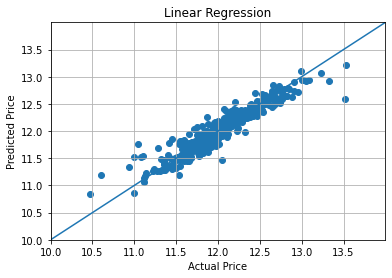

In [11]:
X = train.copy()
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show()

Next the linear regression using the whole of X and Y.

In [12]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives an **RMSE score of 0.14176**, similar to the score in step 4 of part 3 (no correlations removed), and slightly worse than that in step 3 of part 4 (weak correlations removed).

**Step 4: Linear regression with only the extended numeric set, no one-hot encoding**

Recall that the extended set of numerical set contained 56 features, and that 49 numerical features remained after we removed the strong correlations above. Here we perform the linear regression using only these 49 numerical features, and so we ignore the one-hot encoded categorical features.

First the train-test split with this reduced set of features.

0.1502829973243899


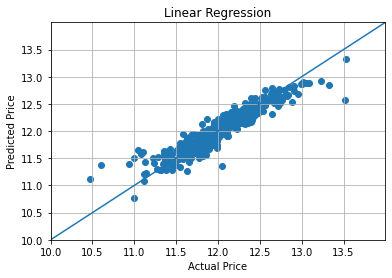

In [13]:
X = X[numeric_features_columns]
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y, using only the 49 numerical features.

In [14]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns]
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14466**.

**Step 5: Linear regression with a smaller set of strong correlations removed.**

Here, for comparison, we only remove correlations between 0.85 and 1, and between -1 and -0.85. Previously we removed correlations between 0.8 and 1, and between -1 and -0.8. We begin with the one-hot encoded features included, reproducing steps 1,2,3 above.

In [15]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)
    
# Remove categorical features with too few unique entries
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries))
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True)

# Replace categorical features with one-hot encoded dummy numerical features
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x)))

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1)
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1)
    train.drop([feature], axis=1, inplace=True)
    test.drop([feature], axis=1, inplace=True)
    
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns))
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns))
train.drop(columns_in_train_but_not_test, axis=1, inplace=True)
test.drop(columns_in_test_but_not_train, axis=1, inplace=True)

# Remove 1 feature from every pair of features whose train columns are strongly correlated
features = list(test.columns)
train['SalePrice'] = train_sale_price['SalePrice']
train_correlations = train.corr()

feature_pairs_with_strong_correlation = []
features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice = []

for feature1 in features:
    for feature2 in features[features.index(feature1)+1:]: 
        if train_correlations[feature1][feature2] > 0.85 or train_correlations[feature1][feature2] < -0.85:
            feature_pairs_with_strong_correlation.append([feature1, feature2])
            if train_correlations[feature1]['SalePrice'] > train_correlations[feature2]['SalePrice']:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature2)
            else:
                features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice.append(feature1)

strongly_correlated_features_to_remove = list(set(features_from_each_strongly_correlated_pair_more_weakly_correlated_with_SalePrice))
numeric_features_columns = list(set(numeric_features_columns) - set(strongly_correlated_features_to_remove))
train.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)
test.drop(strongly_correlated_features_to_remove, axis=1, inplace=True)

# Log transformation of train SalePrice
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

52
(1460, 193)
(1459, 193)


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Of the 56 features in the extended numerical set, 52 remain after removing the strong correlations. Of the 213 total features, 193 remain. Next the train-test split linear regression with this reduced set of features.

0.14162133124313656


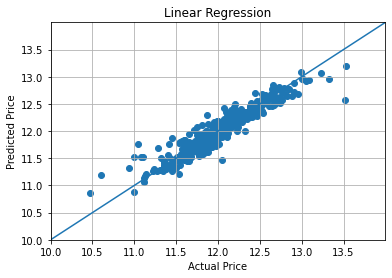

In [16]:
X = train.copy()
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y, with this reduced set of features.

In [17]:
model = lr.fit(X, Y)
X_test = test.copy()
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14220**, similar to that obtained in step 3 when we removed correlations between 0.8 and 1, and between -1 and -0.8.

Next the train-test split linear regression with the 52 numerical features, ignoring the one-hot encoded categorical features.

0.14995056819949482


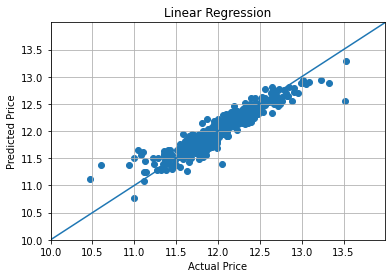

In [18]:
X = X[numeric_features_columns]
x_train = x_train[numeric_features_columns]
x_test = x_test[numeric_features_columns]

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Finally the linear regression using the whole of X and Y, using only the 52 numerical features.

In [19]:
model = lr.fit(X, Y)
X_test = X_test[numeric_features_columns]
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting to kaggle gives a **RMSE score of 0.14463**, similar to that obtained in step 4.